**Dataset:** `decisiontree_Data.csv` (Age, Salary → Purchased)  

---

## Decision Tree Assignment Steps

1. **Import the data files into new data frames**
2. **Create the predictors**
3. **Create the target variable**
4. **Obtain the data set for decision trees**
5. **Split the data into training and testing data sets**
6. **Decision Trees for Classification using `DecisionTreeClassifier`**
7. **Visualize Decision Trees for Classification**
8. **Make a forecast / prediction**
9. **Performance analysis**
10. **Group discussion: findings + recommendations (include disagreements)**
11. **Group discussion: how decision trees are used in organizations + value to team members (include disareements)**
      

In [137]:
# 1) Imports (all required libraries in one place)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

%matplotlib inline


## 2) Load the dataset into a DataFrame
**What we do:** Read the CSV into pandas.  
**Why this step matters:** We need the data in a structured table format (rows/columns) before modeling.


In [139]:
# Read the dataset (make sure the path is correct for your system)
data_path = (r"C:\Users\vanam\Downloads\decisionTree_Data.csv")
df = pd.read_csv(data_path)

# Quick checks
print("Shape (rows, columns):", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(10))


Shape (rows, columns): (400, 3)
Columns: ['Age', 'Salary', 'Purchased']


,Age,Salary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0
5,27,58000,0
6,27,84000,0
7,32,150000,1
8,25,33000,0
9,35,65000,0


## 3) Understand the data (EDA)
We check 4 things:
1. **Data types** (are columns numeric or text?)  
2. **Missing values** (any blanks we must handle?)  
3. **Summary statistics** (min/max/mean)  
4. **Class balance** (how many 0 vs 1 in Purchased?)

**Why this step matters:** Data quality issues or class imbalance can change how we evaluate a model.


Age          int64
Salary       int64
Purchased    int64
dtype: object


Missing values per column:


Age          0
Salary       0
Purchased    0
dtype: int64


Summary statistics:


,Age,Salary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


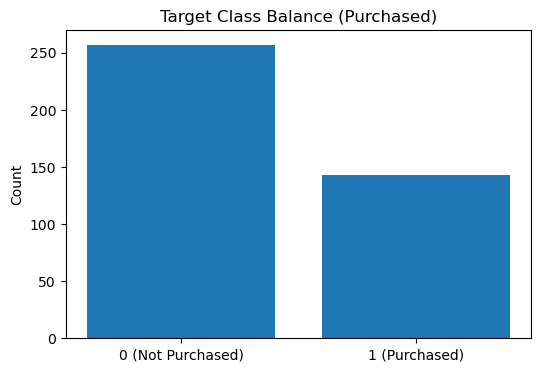

,Count
Purchased,
0,257
1,143


In [141]:
# 3.1 Data types
display(df.dtypes)

# 3.2 Missing values
print("\nMissing values per column:")
display(df.isna().sum())

# 3.3 Summary statistics
print("\nSummary statistics:")
display(df.describe())

# 3.4 Class balance
counts = df["Purchased"].value_counts().sort_index()
plt.figure(figsize=(6,4))
plt.bar(["0 (Not Purchased)", "1 (Purchased)"], counts.values)
plt.title("Target Class Balance (Purchased)")
plt.ylabel("Count")
plt.show()

display(counts.to_frame("Count"))


### Interpretation notes (you can say this in presentation)
- If one class is much larger than the other, accuracy alone can be misleading.  
- Here, we also use ROC/AUC and Precision–Recall to get a better view.


## 4) Visualize predictors (Age and Salary)
We create visuals to see patterns before modeling.

**Why this step matters:**  
If Age and Salary naturally separate customers into buyers vs non-buyers, a decision tree can learn strong rules.


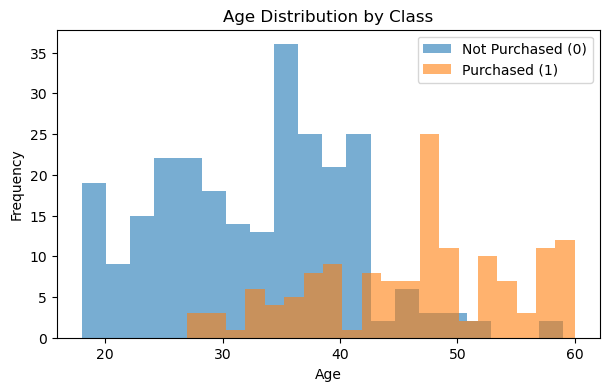

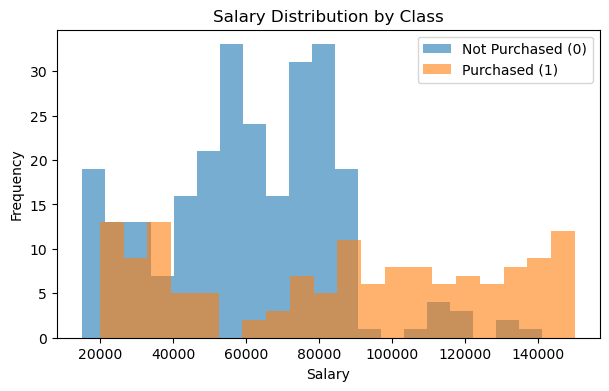

In [144]:
# Split data by target class for clearer plots
df0 = df[df["Purchased"] == 0]
df1 = df[df["Purchased"] == 1]

# Age distribution
plt.figure(figsize=(7,4))
plt.hist(df0["Age"], bins=20, alpha=0.6, label="Not Purchased (0)")
plt.hist(df1["Age"], bins=20, alpha=0.6, label="Purchased (1)")
plt.title("Age Distribution by Class")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Salary distribution
plt.figure(figsize=(7,4))
plt.hist(df0["Salary"], bins=20, alpha=0.6, label="Not Purchased (0)")
plt.hist(df1["Salary"], bins=20, alpha=0.6, label="Purchased (1)")
plt.title("Salary Distribution by Class")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### What to say about these plots
- If the Purchased (1) histogram shifts higher than Not Purchased (0), it means that feature helps prediction.  
- Usually, **higher salary and certain age groups** tend to purchase more in this dataset.


## 5) Scatter plot (Age vs Salary) colored by Purchased
This is one of the best visuals for this dataset.

**Why this step matters:**  
It shows if there is a “region” in Age/Salary space where people mostly purchase.


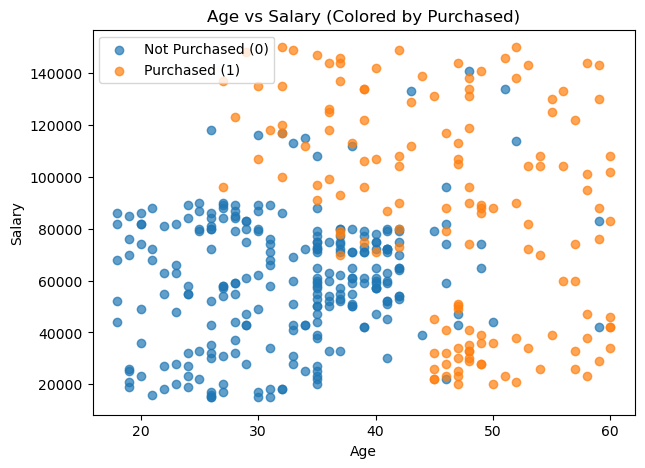

In [147]:
plt.figure(figsize=(7,5))
plt.scatter(df0["Age"], df0["Salary"], alpha=0.7, label="Not Purchased (0)")
plt.scatter(df1["Age"], df1["Salary"], alpha=0.7, label="Purchased (1)")
plt.title("Age vs Salary (Colored by Purchased)")
plt.xlabel("Age")
plt.ylabel("Salary")
plt.legend()
plt.show()


### Interpretation (simple)
- Each dot is a customer.
- If the dots for Purchased=1 cluster in a certain area (like higher salary), a tree can learn rules to capture that.


## 6) Create predictors (X) and target (y)
- **X (features/predictors):** columns used to predict  
- **y (target/label):** the outcome we want

Here:
- `X = [Age, Salary]`
- `y = Purchased`


In [150]:
# Features (predictors)
X = df[["Age", "Salary"]]

# Target label
y = df["Purchased"]

print("X shape:", X.shape)
print("y shape:", y.shape)
display(X.head())
display(y.head())


X shape: (400, 2)
y shape: (400,)


,Age,Salary
0,19,19000
1,35,20000
2,26,43000
3,27,57000
4,19,76000


0    0
1    0
2    0
3    0
4    0
Name: Purchased, dtype: int64

## 7) Split into training and testing sets 
**What we do:** Split data into:
- Training (learn patterns)
- Testing (check performance on unseen data)

**Why this step matters:**  
If we test on the same data used to train, the score can look “too good” and not reflect real performance.

### Why we used `stratify=y`
It keeps the **same ratio of Purchased 0/1** in both train and test.  
This is important so the test set is fair and not biased.


In [152]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

print("\nTrain class balance (percentage):")
display((y_train.value_counts(normalize=True).sort_index() * 100).round(2).to_frame("%"))

print("\nTest class balance (percentage):")
display((y_test.value_counts(normalize=True).sort_index() * 100).round(2).to_frame("%"))


Train size: (320, 2)  Test size: (80, 2)

Train class balance (percentage):


,%
Purchased,
0,64.38
1,35.62



Test class balance (percentage):


,%
Purchased,
0,63.75
1,36.25


## 8) Train a Decision Tree classifier 
**What we do:** Train `DecisionTreeClassifier`.

### Key parameters (easy explanation)
- `criterion="gini"`: measures split quality (how “pure” the split is).  
- `max_depth=3`: limits tree depth for readability and avoids overfitting.  
- `random_state=42`: makes results reproducible.

**Why this step matters:**  
A tree learns **if-else rules** like:  
> If Salary > X and Age > Y → predict Purchased=1


In [154]:
# Build a simple, interpretable tree first
dt_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
    random_state=42
)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Probability of class 1 (Purchased=1), used for ROC/PR curves
y_proba = dt_model.predict_proba(X_test)[:, 1]

# Basic accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", round(acc, 4))

Test Accuracy: 0.8875


## 9) Visualize the Decision Tree
**What this plot means:**
- Each box is a decision rule (example: `Salary <= 67500`)
- Left branch = rule is True, right branch = False
- `gini`: impurity (0 means perfect separation)
- `samples`: number of training rows reaching that node
- `value`: counts of class 0 and class 1 in that node
- `class`: predicted class at that node (majority class)

**Why this matters:**  
This is the **explainability advantage** of decision trees. You can show rules to non-technical stakeholders.


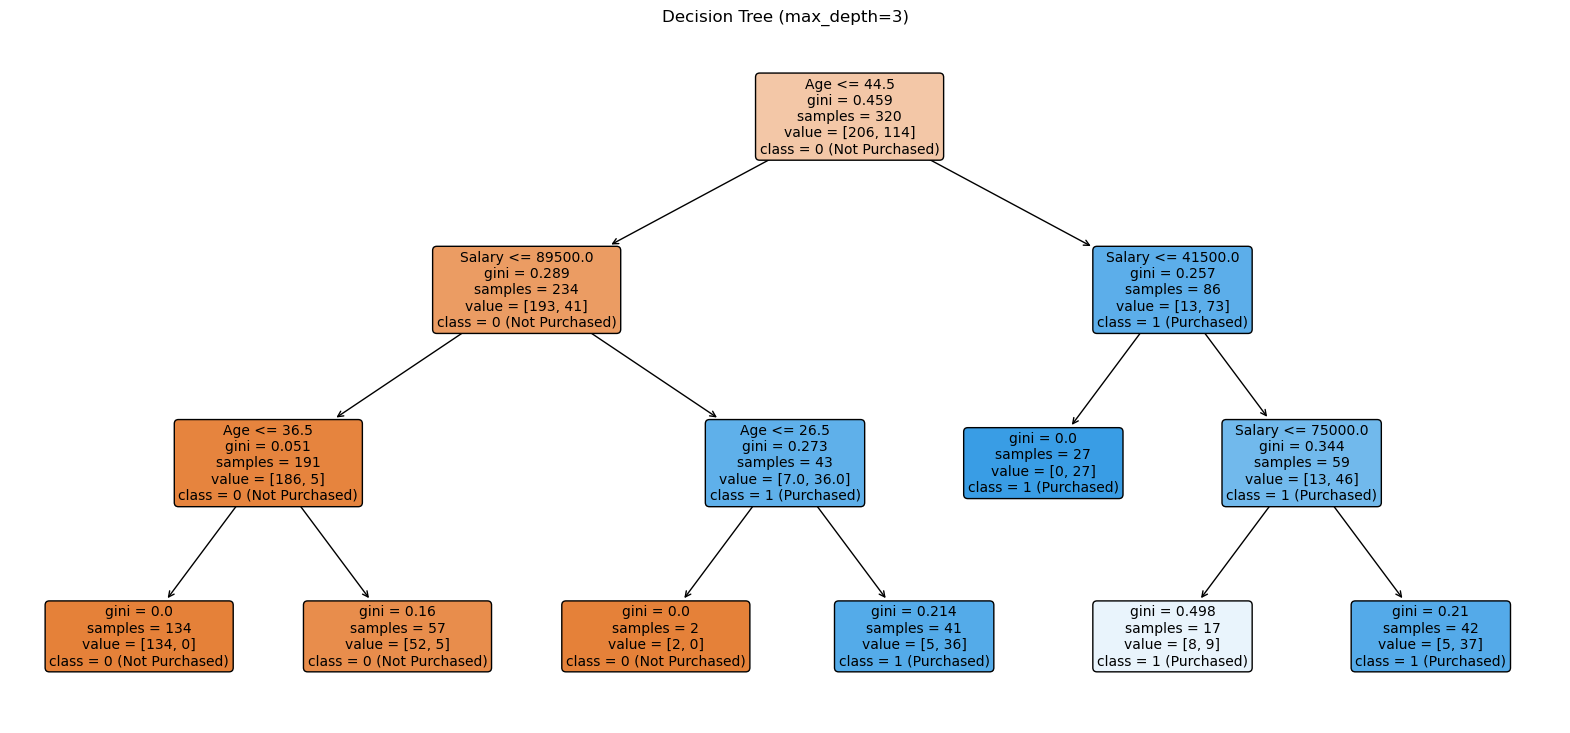

In [156]:
plt.figure(figsize=(20, 9))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=["0 (Not Purchased)", "1 (Purchased)"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree (max_depth=3)")
plt.show()


## 10) Decision regions
This is a strong presentation visual.

**What this plot shows:**
- Background shading = model prediction across the Age/Salary space  
- Points = actual customers  
- If many Purchased=1 points fall inside the region predicted as 1 → model is doing well.

**Why this matters:**  
It connects the “math model” to a very clear picture of how the tree draws boundaries.


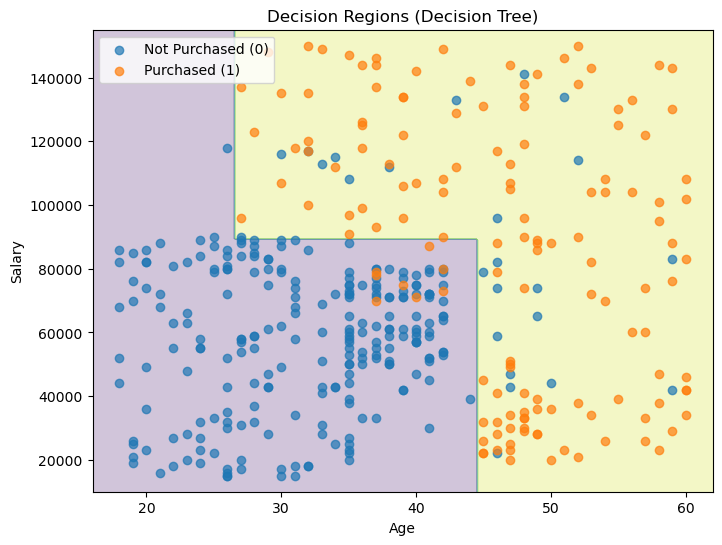

In [158]:
# Create a fine grid over Age and Salary to visualize predictions
age_min, age_max = X["Age"].min() - 2, X["Age"].max() + 2
sal_min, sal_max = X["Salary"].min() - 5000, X["Salary"].max() + 5000

age_grid = np.linspace(age_min, age_max, 300)
sal_grid = np.linspace(sal_min, sal_max, 300)
xx, yy = np.meshgrid(age_grid, sal_grid)

# Prepare grid points
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Convert to DataFrame with correct feature names
grid_df = pd.DataFrame(grid_points, columns=X.columns)

# Predict class for every grid point
grid_pred = dt_model.predict(grid_df).reshape(xx.shape)

# Plot background decision regions
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, grid_pred, alpha=0.25)

# Overlay actual data points
plt.scatter(df0["Age"], df0["Salary"], alpha=0.7, label="Not Purchased (0)")
plt.scatter(df1["Age"], df1["Salary"], alpha=0.7, label="Purchased (1)")

plt.title("Decision Regions (Decision Tree)")
plt.xlabel("Age")
plt.ylabel("Salary")
plt.legend()
plt.show()


## 11) Make a forecast / prediction
**What we do:** Predict for a new example person.

We show:
- predicted class (0 or 1)
- predicted probability of purchase (class 1)

**Why this matters:**  
In business, probabilities are useful for “who to target first” (higher probability customers).


In [160]:
# Example: new customer details
new_customer = pd.DataFrame({"Age": [30], "Salary": [60000]})

pred_class = dt_model.predict(new_customer)[0]
pred_prob = dt_model.predict_proba(new_customer)[0, 1]

print("New customer:", new_customer.iloc[0].to_dict())
print("Predicted class (0=No, 1=Yes):", pred_class)
print("Probability of Purchased (class 1):", round(pred_prob, 4))


New customer: {'Age': 30, 'Salary': 60000}
Predicted class (0=No, 1=Yes): 0
Probability of Purchased (class 1): 0.0


## 12) Performance analysis 
We evaluate using:
1. Confusion Matrix (TP/FP/TN/FN)
2. Classification Report (precision, recall, f1-score)
3. ROC Curve + AUC
4. Precision–Recall Curve

### Confusion matrix explanation
- **TN:** predicted 0, actual 0 (correct non-purchase)
- **TP:** predicted 1, actual 1 (correct purchase)
- **FP:** predicted 1, actual 0 (false alarm)
- **FN:** predicted 0, actual 1 (missed buyer)


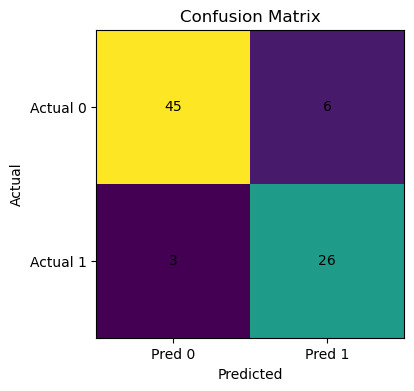

,Pred 0,Pred 1
Actual 0 (Not Purchased),45,6
Actual 1 (Purchased),3,26


Classification Report:
              precision    recall  f1-score   support

           0      0.938     0.882     0.909        51
           1      0.812     0.897     0.852        29

    accuracy                          0.887        80
   macro avg      0.875     0.889     0.881        80
weighted avg      0.892     0.887     0.889        80



In [162]:
# 12.1 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visual confusion matrix (simple image)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["Actual 0", "Actual 1"])

# Write numbers inside cells
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Table version (good for report)
cm_df = pd.DataFrame(
    cm,
    index=["Actual 0 (Not Purchased)", "Actual 1 (Purchased)"],
    columns=["Pred 0", "Pred 1"]
)
display(cm_df)

# 12.2 Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))


### How to explain the classification report
- **Precision:** when the model predicts “Purchased=1”, how often it is correct.  
- **Recall:** out of all real Purchased=1 customers, how many we correctly found.  
- **F1-score:** balance between precision and recall.  
- **Support:** number of samples in each class.


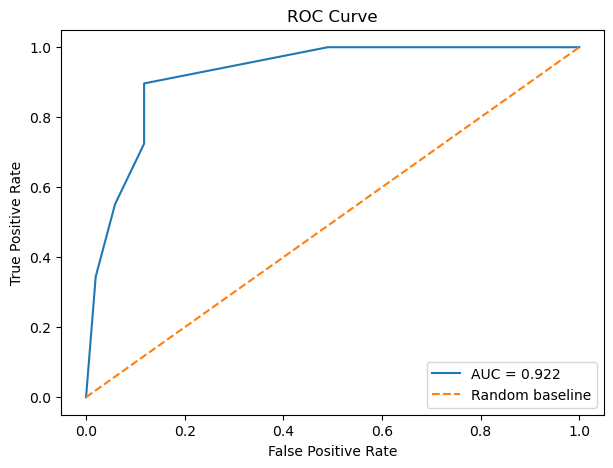

AUC: 0.9216


In [164]:
# 12.3 ROC Curve + AUC
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random baseline")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("AUC:", round(auc, 4))


### What to say about ROC/AUC
- ROC shows performance across different probability thresholds.
- **AUC ranges 0 to 1**:  
  - 0.5 means random guessing  
  - closer to 1 means strong separation ability


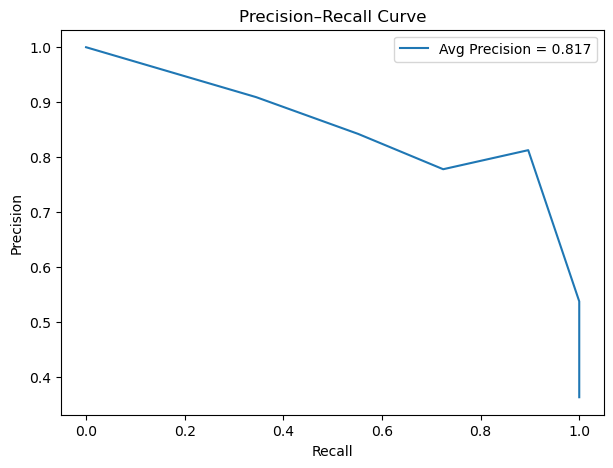

Average Precision: 0.8174


In [166]:
# 12.4 Precision–Recall Curve
ap = average_precision_score(y_test, y_proba)
precision, recall, thr = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"Avg Precision = {ap:.3f}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

print("Average Precision:", round(ap, 4))


### When PR curve is useful
If the dataset becomes imbalanced (very few Purchased=1), PR curve is often more informative than ROC.


## 13) Tune the Decision Tree (Grid Search) 
**What we do:** Try many combinations of parameters and pick the best using cross-validation.

### What is cross-validation?
The training data is split into folds (here 5 folds).  
The model trains on 4 folds and validates on 1 fold, repeated 5 times.  
We average the score → more reliable than a single split.

### Parameters we tune
- `max_depth`: controls complexity (depth)
- `min_samples_split`: minimum samples to split a node
- `min_samples_leaf`: minimum samples per leaf


In [169]:
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", round(grid.best_score_, 4))

best_dt = grid.best_estimator_
best_pred = best_dt.predict(X_test)
best_proba = best_dt.predict_proba(X_test)[:, 1]

print("Tuned Test Accuracy:", round(accuracy_score(y_test, best_pred), 4))


Best parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best CV accuracy: 0.9156
Tuned Test Accuracy: 0.8625


## 13A) Grid Search results visualization 
This plot answers a common question:
> “How does accuracy change when the tree depth changes?”

We average accuracy for each `max_depth` across the other parameter settings.


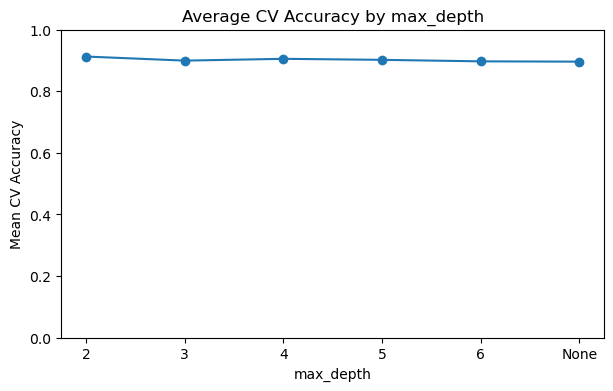

,param_max_depth,mean_test_score
0,2,0.912500
1,3,0.899219
2,4,0.905078
3,5,0.901758
4,6,0.896875
5,None,0.895898


In [171]:
results = pd.DataFrame(grid.cv_results_)

# Keep only what we need
small = results[["param_max_depth", "mean_test_score"]].copy()

# Replace None depth with a label (for plotting)
small["param_max_depth"] = small["param_max_depth"].astype(object).where(
    small["param_max_depth"].notna(), "None"
)

# Mean CV score for each depth
depth_scores = small.groupby("param_max_depth")["mean_test_score"].mean().reset_index()

# Sort for nicer plotting order
order = [2, 3, 4, 5, 6, "None"]
depth_scores["order"] = depth_scores["param_max_depth"].apply(lambda x: order.index(x) if x in order else 999)
depth_scores = depth_scores.sort_values("order")

plt.figure(figsize=(7,4))
plt.plot(depth_scores["param_max_depth"].astype(str), depth_scores["mean_test_score"], marker="o")
plt.title("Average CV Accuracy by max_depth")
plt.xlabel("max_depth")
plt.ylabel("Mean CV Accuracy")
plt.ylim(0, 1)
plt.show()

display(depth_scores[["param_max_depth", "mean_test_score"]])


## 14) Visualize the tuned tree
If the best tree becomes too deep, the plot becomes unreadable.  
So we only plot it if it is not too deep (<= 5 levels).


Best tree depth: 4


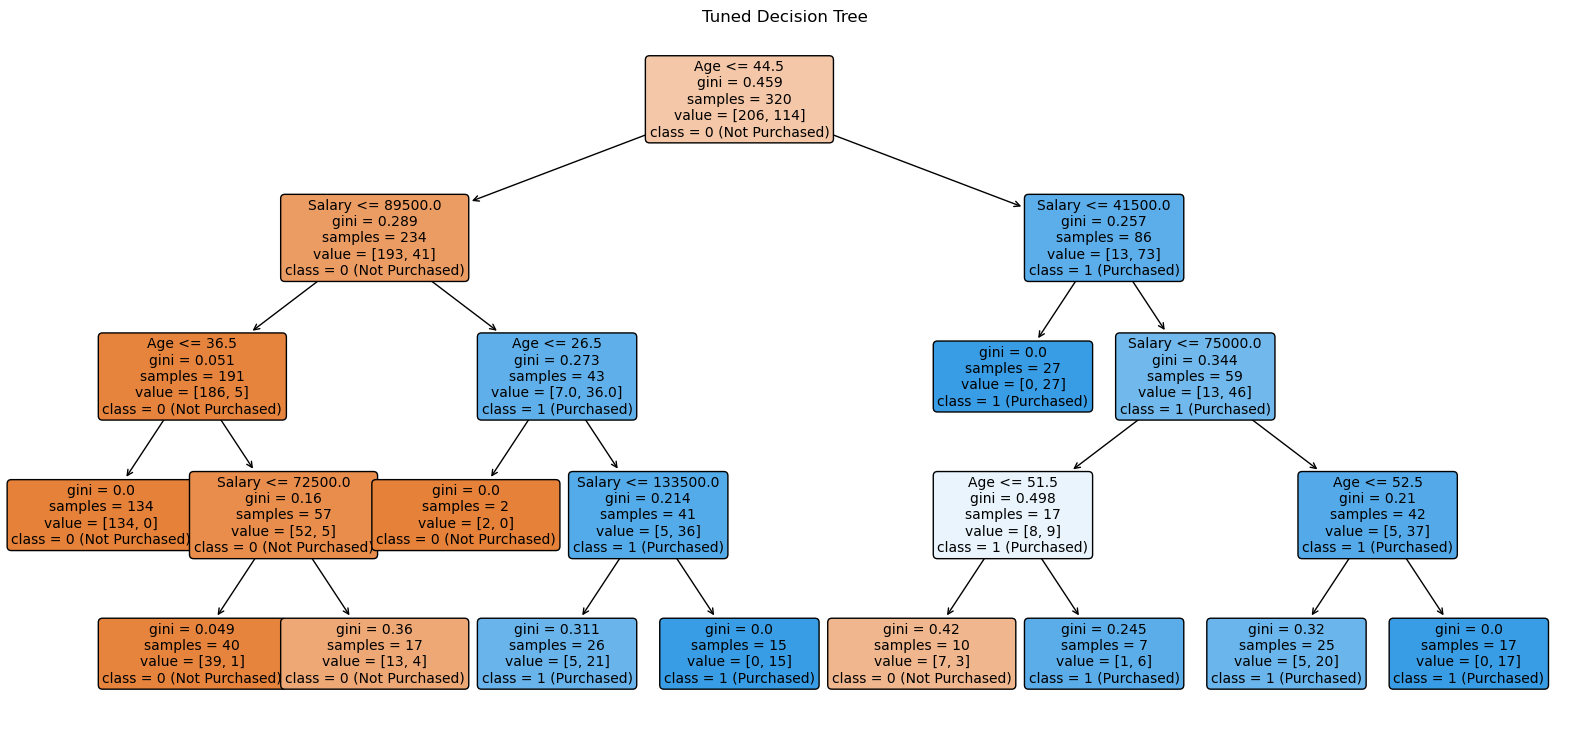

In [173]:
depth = best_dt.get_depth()
print("Best tree depth:", depth)

if depth <= 5:
    plt.figure(figsize=(20, 9))
    plot_tree(
        best_dt,
        feature_names=X.columns,
        class_names=["0 (Not Purchased)", "1 (Purchased)"],
        filled=True,
        rounded=True,
        fontsize=10
    )
    plt.title("Tuned Decision Tree")
    plt.show()
else:
    print("Tree is deeper than 5 levels. Skipping full tree plot to keep notebook readable.")


rithn real-world organizational decision-making.
